## Setup

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

## configuration

In [2]:
CENTER_NAME   = "RevenueCenter_1"
DATA_DIR      = "revenue_center_data"
FILE_PATH     = os.path.join(DATA_DIR, f"{CENTER_NAME}_data.csv")
LOW_IMPACT    = ["IsArtDubai", "IsFilmFestival", "IsWorldCup"]
FORECAST_DAYS = 90            # ≈ three months
VALID_START   = "2023-10-01"  # use last 3 months for validation


# Numeric encoding maps  ------------------------------------------
TI_MAP = {"Low": 0, "Normal": 1, "Medium": 2, "High": 3}
RI_MAP = {"Decrease": -1, "Neutral": 0, "Boost": 1}

# 2. LOAD & PRE‑PROCESS DATA

In [4]:
TI_MAP = {"Low": 0, "Normal": 1, "Medium": 2, "High": 3}
RI_MAP = {"Decrease": -1, "Neutral": 0, "Boost": 1}

In [3]:
assert os.path.exists(FILE_PATH), f"CSV not found → {FILE_PATH}"
raw = pd.read_csv(FILE_PATH, parse_dates=["Date"])

raw.drop(columns=[c for c in LOW_IMPACT if c in raw.columns], inplace=True, errors="ignore")

for col in ["Date", "MealPeriod", "CheckTotal"]:
    if col not in raw.columns:
        raise KeyError(f"Missing column: {col}")

flag_cols = [c for c in raw.columns if c.startswith("Is") and c != "IslamicPeriod"]
for f in flag_cols:
    raw[f] = raw[f].fillna(0).astype(int)

raw["TourismIntensity"] = raw["TourismIntensity"].map(TI_MAP).fillna(1).astype(int)
raw["RevenueImpact"]     = raw["RevenueImpact"].map(RI_MAP).fillna(0).astype(int)

print("✓ Pre-processing done →", raw.shape)
print(raw.head(2))

✓ Pre-processing done → (1458, 26)
        Date MealPeriod RevenueCenterName  DayOfWeek  Month  Year  CheckTotal  \
0 2023-01-01  Breakfast   RevenueCenter_1          6      1  2023      1499.4   
1 2023-01-01     Dinner   RevenueCenter_1          6      1  2023      4374.5   

   is_zero          IslamicPeriod  IsRamadan  ...  IsNationalDay  IsNewYear  \
0        0  New-Year-Celebrations          0  ...              0          1   
1        0  New-Year-Celebrations          0  ...              0          1   

   IsMarathon  IsGITEX  IsAirshow  IsFoodFestival  IsPreEvent  IsPostEvent  \
0           0        0          0               0           0            0   
1           0        0          0               0           0            0   

   TourismIntensity  RevenueImpact  
0                 3              1  
1                 3              1  

[2 rows x 26 columns]


# 3. TRAIN & VALIDATE PER MEAL PERIOD

15:23:24 - cmdstanpy - INFO - Chain [1] start processing
15:23:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



Breakfast Diagnostics:
  Training samples: 273
  Validation samples: 213
  Actual range: 0 - 8211
  Predicted range: -843 - 1164
  Mean actual: 1281.82
  Mean predicted: 280.52
  Std actual: 1206.91
  Std predicted: 486.29
  Most negative prediction: -843.20
  Prediction/Actual ratio: 0.219
  Sample comparisons (Actual vs Predicted):
    2143 vs 929 (diff: 1214)
    125 vs 880 (diff: 755)
    263 vs 738 (diff: 475)
    258 vs 818 (diff: 560)
    472 vs 816 (diff: 344)


c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


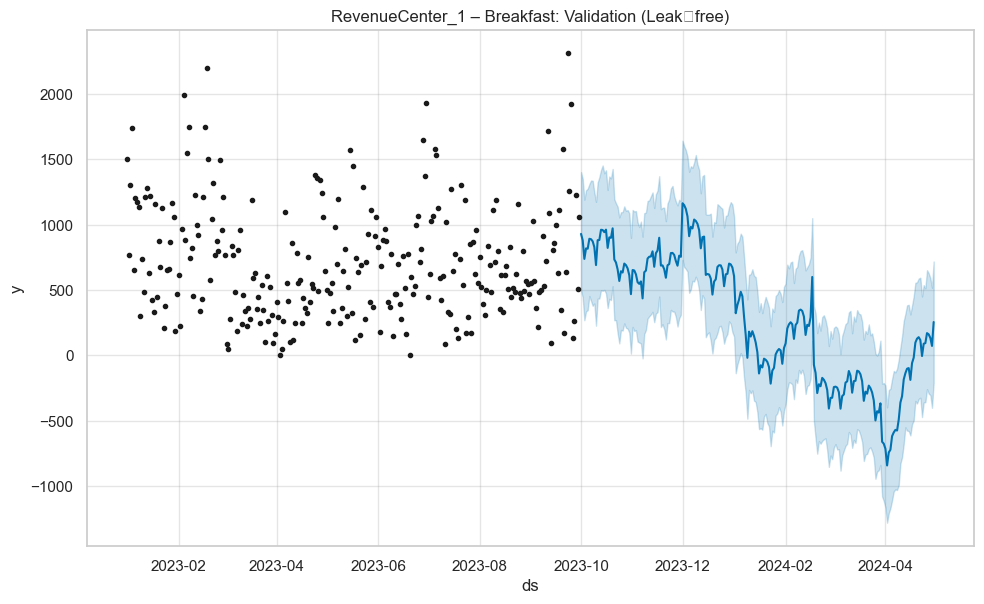

15:23:24 - cmdstanpy - INFO - Chain [1] start processing
15:23:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s


Dinner Diagnostics:
  Training samples: 273
  Validation samples: 213
  Actual range: 688 - 10052
  Predicted range: -4444 - 6300
  Mean actual: 3247.33
  Mean predicted: -456.82
  Std actual: 1937.84
  Std predicted: 2475.07
  Most negative prediction: -4444.34
  Prediction/Actual ratio: -0.141
  Sample comparisons (Actual vs Predicted):
    1476 vs 774 (diff: 702)
    1468 vs 911 (diff: 557)
    1213 vs 743 (diff: 470)
    1342 vs 335 (diff: 1007)
    1091 vs 892 (diff: 199)


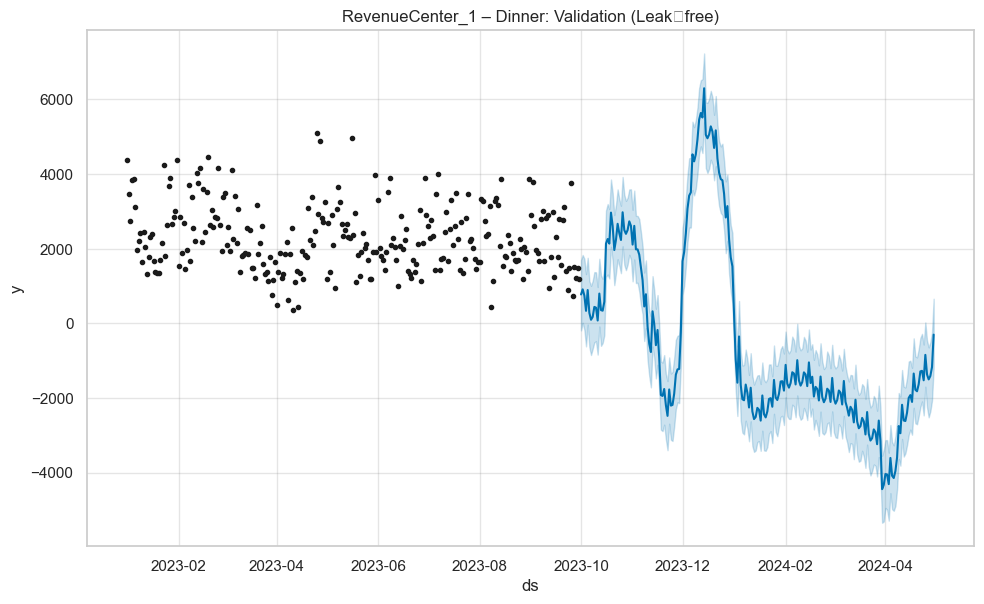

15:23:25 - cmdstanpy - INFO - Chain [1] start processing
15:23:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s


Lunch Diagnostics:
  Training samples: 273
  Validation samples: 213
  Actual range: 0 - 4504
  Predicted range: 332 - 2057
  Mean actual: 913.20
  Mean predicted: 1071.81
  Std actual: 858.19
  Std predicted: 395.42
  Prediction/Actual ratio: 1.174
  Sample comparisons (Actual vs Predicted):
    142 vs 784 (diff: 642)
    118 vs 834 (diff: 716)
    220 vs 843 (diff: 623)
    613 vs 879 (diff: 266)
    180 vs 877 (diff: 697)


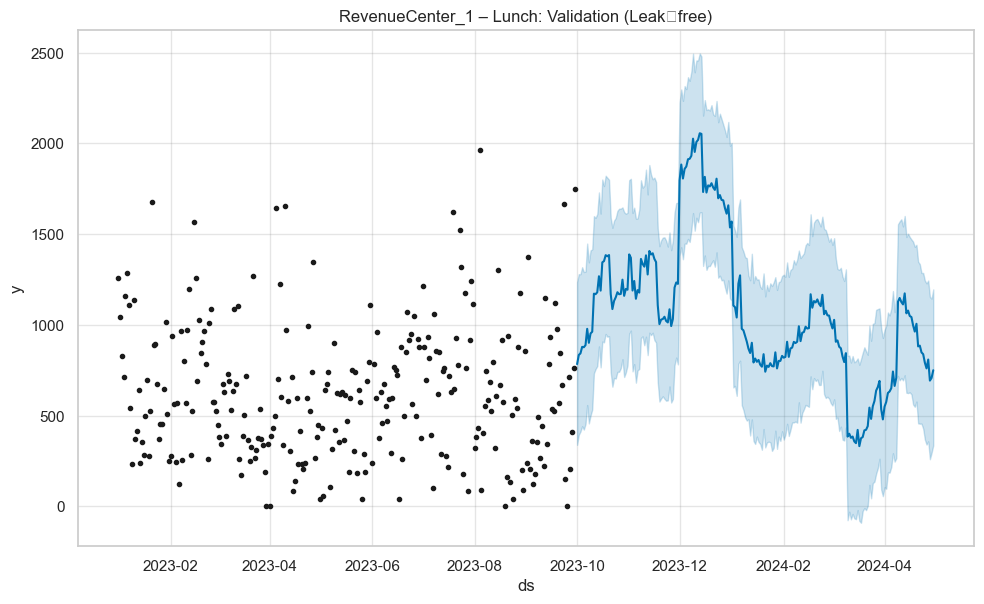

In [6]:
# Get unique meal periods (e.g., Breakfast, Lunch, Dinner)
MEALS = sorted(raw["MealPeriod"].unique())
results = []

for meal in MEALS:
    # --- DATA PREPARATION ---
    # Filter data for current meal period and prepare for Prophet model format
    dfm = raw[raw["MealPeriod"] == meal].copy()
    dfm = dfm.rename(columns={"Date": "ds", "CheckTotal": "y"})
    
    # Get all flag columns that start with "Is" (excluding IslamicPeriod)
    # These represent binary indicators for various events/conditions
    flag_cols = [c for c in raw.columns if c.startswith("Is") and c != "IslamicPeriod"]

    # Fill any missing values with 0 and convert to integers (0 or 1)
    # This ensures all flag columns contain only binary values
    for f in flag_cols:
        dfm[f] = dfm[f].fillna(0).astype(int)

    # --- HOLIDAY HANDLING ---
    # Create a dataframe to store holiday events for Prophet model
    # Prophet requires holidays in a specific format with 'holiday' name and 'ds' date
    hol_rows = []

    # Process Ramadan and Eid periods as special holiday events
    # These are important religious periods that can affect business patterns
    for flag, label in [("IsRamadan", "Ramadan"), ("IsEid", "Eid")]:
        # Check if this holiday flag exists in our dataset
        if flag in dfm.columns:
            # Create a dataframe for dates where this holiday occurs (flag == 1)
            # 'holiday' column contains the holiday name (Ramadan/Eid)
            # 'ds' column contains the dates when this holiday occurs
            hol_rows.append(pd.DataFrame({                                       
                "holiday": label,
                "ds": dfm.loc[dfm[flag]==1, "ds"]
            }))

    # Combine all holiday dataframes into one
    # If no holidays were found, create an empty dataframe
    # ignore_index=True ensures clean row numbering
    holidays = pd.concat(hol_rows, ignore_index=True) if hol_rows else pd.DataFrame()
        
    # --- MODEL INITIALIZATION ---
    # Initialize Prophet model with weekly and yearly seasonality, plus holidays
    m = Prophet(holidays=holidays, weekly_seasonality=True, yearly_seasonality=True)

    # --- REGRESSOR SETUP ---
    # Get all binary flags (Is*) and impact columns as regressors
    regressors = [c for c in dfm.columns if c.startswith("Is") and c != "IslamicPeriod"] + ["TourismIntensity", "RevenueImpact"]
    regressors = list(dict.fromkeys(regressors))  # Remove any duplicates
    for r in regressors:
        if r in dfm.columns:  # Add each regressor to model
            m.add_regressor(r)

    # --- TRAIN/VALIDATION SPLIT ---
    train = dfm[dfm["ds"] < VALID_START]  # Training data before VALID_START
    valid = dfm[dfm["ds"] >= VALID_START]  # Validation data after VALID_START

    # Skip if insufficient training data
    if len(train) < 30:
        print(f"Warning: Only {len(train)} training samples for {meal}")
        continue

    # --- MODEL TRAINING ---
    # Train model on historical data with all regressors
    m.fit(train[["ds", "y"] + [r for r in regressors if r in dfm.columns]])

    # --- PREDICTION ---
    # Prepare validation features
    future_valid = valid[["ds"]].copy()
    for r in regressors:
        if r in dfm.columns:
            future_valid[r] = valid[r]

    # Generate predictions
    forecast_v = m.predict(future_valid)

    # --- EVALUATION METRICS ---
    actual = valid["y"].values
    predicted = forecast_v["yhat"].values

    # Calculate various error metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = mean_squared_error(actual, predicted, squared=False)

    # Calculate MAPE (Mean Absolute Percentage Error) for non-zero actuals
    nonzero_mask = actual != 0
    if np.sum(nonzero_mask) > 0:
        mape = np.mean(np.abs((actual[nonzero_mask] - predicted[nonzero_mask]) / actual[nonzero_mask])) * 100
        mape = min(mape, 999.99)  # Cap MAPE for display
    else:
        mape = np.nan

    r2 = r2_score(actual, predicted)

    # --- ACCURACY METRICS ---
    # SMAPE (Symmetric Mean Absolute Percentage Error)
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))) * 100
    accuracy_smape = max(0, 100 - smape)

    # Relative accuracy based on RMSE vs mean
    mean_actual = np.mean(actual)
    accuracy_relative = max(0, 100 - (rmse / mean_actual * 100)) if mean_actual > 0 else 0

    # R² based accuracy
    accuracy_r2 = max(0, r2 * 100) if r2 > 0 else r2 * 100

    # Store results for this meal period
    results.append({
        "Meal": meal,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE_%": round(mape, 2) if not np.isnan(mape) else "N/A",
        "SMAPE_%": round(smape, 2),
        "Acc_SMAPE_%": round(accuracy_smape, 2),
        "Acc_Relative_%": round(accuracy_relative, 2),
        "R²": round(r2, 3),
        "Acc_R²_%": round(accuracy_r2, 2)
    })

    # --- DIAGNOSTIC INFORMATION ---
    print(f"\n{meal} Diagnostics:")
    print(f"  Training samples: {len(train)}")
    print(f"  Validation samples: {len(valid)}")
    print(f"  Actual range: {actual.min():.0f} - {actual.max():.0f}")
    print(f"  Predicted range: {predicted.min():.0f} - {predicted.max():.0f}")
    print(f"  Mean actual: {np.mean(actual):.2f}")
    print(f"  Mean predicted: {np.mean(predicted):.2f}")
    print(f"  Std actual: {np.std(actual):.2f}")
    print(f"  Std predicted: {np.std(predicted):.2f}")

    # Check for negative predictions (which shouldn't occur for revenue)
    if np.any(predicted < 0):
        negative_count = np.sum(predicted < 0)
        print(f"  WARNING: {negative_count} negative predictions!")
        print(f"  Most negative prediction: {predicted.min():.2f}")

    # Check if predictions are in same scale as actuals
    prediction_ratio = np.mean(predicted) / np.mean(actual) if np.mean(actual) > 0 else 0
    print(f"  Prediction/Actual ratio: {prediction_ratio:.3f}")

    if prediction_ratio < 0.1 or prediction_ratio > 10:
        print(f"  WARNING: Predictions are {prediction_ratio:.1f}x the actual values!")

    # Show sample predictions vs actuals
    print(f"  Sample comparisons (Actual vs Predicted):")
    for i in range(min(5, len(actual))):
        print(f"    {actual[i]:.0f} vs {predicted[i]:.0f} (diff: {abs(actual[i]-predicted[i]):.0f})")

    # Plot results
    m.plot(forecast_v)
    plt.title(f"{CENTER_NAME} – {meal}: Validation (Leak‐free)")
    plt.show()

In [7]:
meal = "Breakfast"
dfb = raw[raw["MealPeriod"] == meal].copy()
dfb.rename(columns={"Date": "ds", "CheckTotal": "y"}, inplace=True)
regressors = [c for c in dfb.columns if c.startswith("Is") and c != "IslamicPeriod"] + ["TourismIntensity", "RevenueImpact"]

m_final = Prophet(holidays=holidays, weekly_seasonality=True, yearly_seasonality=True)
for r in regressors:
    m_final.add_regressor(r)

m_final.fit(dfb[["ds", "y"] + regressors])
future = m_final.make_future_dataframe(periods=FORECAST_DAYS)
for r in regressors:
    future[r] = dfb[r].iloc[-1]
forecast = m_final.predict(future)
forecast.to_csv("forecast_RC1_Breakfast.csv", index=False)
print("✅ Breakfast 90‑day forecast saved → forecast_RC1_Breakfast.csv")

15:34:18 - cmdstanpy - INFO - Chain [1] start processing
15:34:18 - cmdstanpy - INFO - Chain [1] done processing


✅ Breakfast 90‑day forecast saved → forecast_RC1_Breakfast.csv


15:36:52 - cmdstanpy - INFO - Chain [1] start processing
15:36:52 - cmdstanpy - INFO - Chain [1] done processing


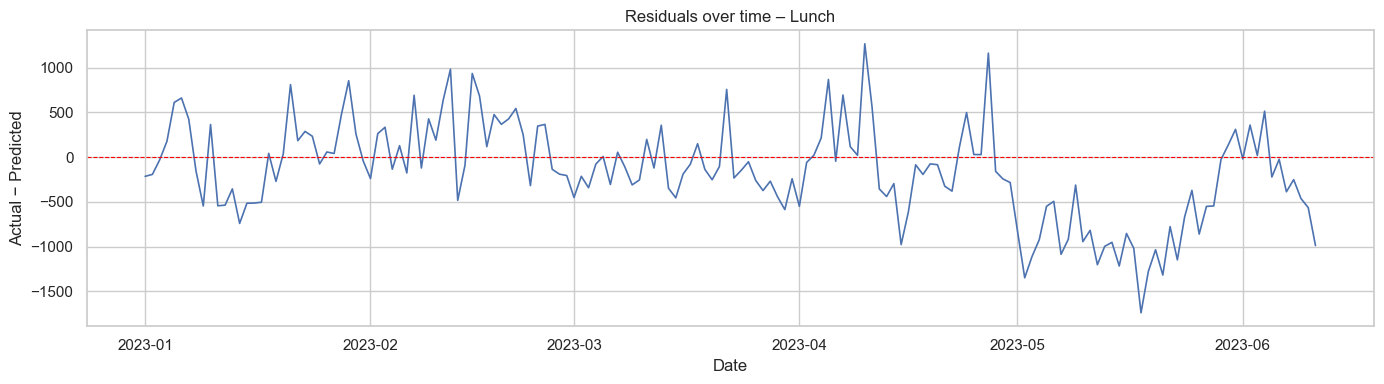

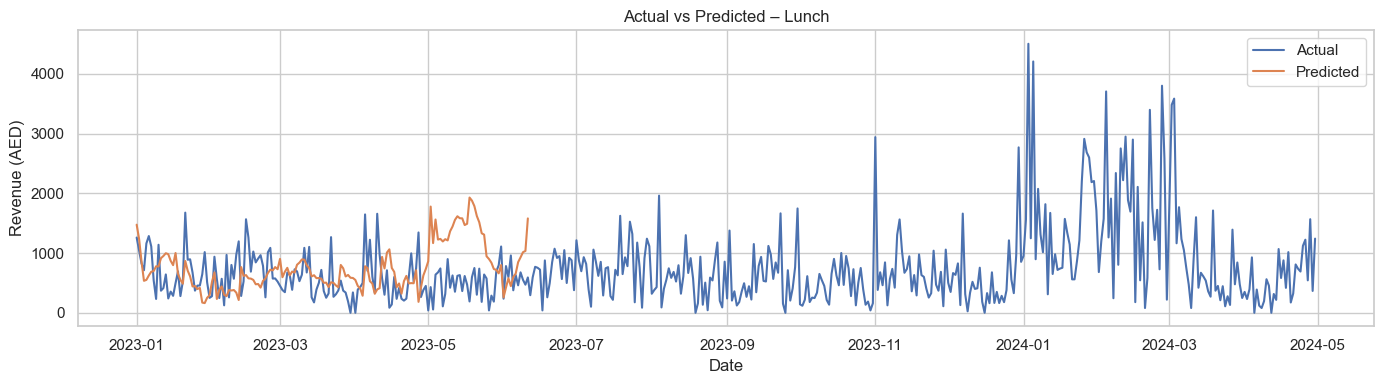


Top ±2σ residual dates:
            ds       y         yhat     residual
299 2023-04-10  1658.0   392.082129  1265.917871
350 2023-04-27  1345.0   183.521449  1161.478551
365 2023-05-02   430.0  1778.571875 -1348.571875
368 2023-05-03    55.0  1167.201437 -1112.201437
380 2023-05-07   108.0  1194.491162 -1086.491162
395 2023-05-12   353.0  1555.452953 -1202.452953
404 2023-05-15   364.0  1580.994903 -1216.994903
413 2023-05-18   190.0  1929.756198 -1739.756198
416 2023-05-19   598.0  1877.704336 -1279.704336
422 2023-05-21   303.0  1620.928454 -1317.928454


In [9]:
import seaborn as sns

diag_meal = "Lunch"  # change to Breakfast / Lunch / Dinner

# Build full‑history forecast for chosen meal
_diag = raw[raw["MealPeriod"] == diag_meal].copy()
_diag.rename(columns={"Date": "ds", "CheckTotal": "y"}, inplace=True)

m_diag = Prophet(holidays=holidays, weekly_seasonality=True, yearly_seasonality=True)
regs_diag = [c for c in _diag.columns if c.startswith("Is") and c != "IslamicPeriod"] + ["TourismIntensity", "RevenueImpact"]
for r in regs_diag:
    m_diag.add_regressor(r)

m_diag.fit(_diag[["ds", "y"] + regs_diag])
forecast_all = m_diag.predict(_diag[["ds"] + regs_diag])
_diag["yhat"] = forecast_all["yhat"]
_diag["residual"] = _diag["y"] - _diag["yhat"]

plt.figure(figsize=(14,4))
sns.lineplot(data=_diag, x="ds", y="residual", lw=1.2)
plt.axhline(0, color="red", ls="--", lw=0.8)
plt.title(f"Residuals over time – {diag_meal}")
plt.ylabel("Actual − Predicted")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# --- NEW: Overlay Actual vs Predicted ---
plt.figure(figsize=(14,4))
sns.lineplot(data=_diag, x="ds", y="y", label="Actual", linewidth=1.5)
sns.lineplot(data=_diag, x="ds", y="yhat", label="Predicted", linewidth=1.5)
plt.title(f"Actual vs Predicted – {diag_meal}")
plt.ylabel("Revenue (AED)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

print("\nTop ±2σ residual dates:")
std_res = _diag["residual"].std()
print(_diag.loc[_diag["residual"].abs() > 2*std_res, ["ds", "y", "yhat", "residual"]].head(10))
